## CSE 8803: Brain-inspired Machine Intelligence

### Lab 4: Neural Coding

Objectives:
- Place Cell and Grid Cell
- Nearest neighbour search in ANN by high-dimensional locality sensitive hashing
- After-class questions (15 points)
  - Grid score and manifold distance (6 points)
  - Neuron coding strategy: population coding and Bayesian decoder (3 points)
  - FlyLSH implementation (6 points)
  - Bonus: Head direction tuning curves (2 points)

Submission guideline for this lab is the same as lab 1.

### Part 1: Place Cell and Grid Cell

In [ ]:
import numpy as np
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt

import math
import scipy
import scipy.stats
import scipy.signal
import scipy.ndimage as ndimage
from imageio import imsave
import cv2
import os

#### Download helper functions and trained weights

In [ ]:
!wget https://raw.githubusercontent.com/ganguli-lab/grid-pattern-formation/refs/heads/master/trajectory_generator.py
!wget https://raw.githubusercontent.com/ganguli-lab/grid-pattern-formation/refs/heads/master/scores.py
!wget https://raw.githubusercontent.com/ganguli-lab/grid-pattern-formation/refs/heads/master/visualize.py
!wget https://raw.githubusercontent.com/ganguli-lab/grid-pattern-formation/refs/heads/master/utils.py
!wget https://raw.githubusercontent.com/ganguli-lab/grid-pattern-formation/refs/heads/master/models/example_trained_weights.npy
!wget https://raw.githubusercontent.com/ganguli-lab/grid-pattern-formation/refs/heads/master/models/example_pc_centers.npy

--2024-10-17 17:13:14--  https://raw.githubusercontent.com/ganguli-lab/grid-pattern-formation/refs/heads/master/trajectory_generator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6619 (6.5K) [text/plain]
Saving to: ‘trajectory_generator.py’

trajectory_generato 100%[===================>]   6.46K  --.-KB/s    in 0s      

2024-10-17 17:13:14 (58.0 MB/s) - ‘trajectory_generator.py’ saved [6619/6619]

--2024-10-17 17:13:14--  https://raw.githubusercontent.com/ganguli-lab/grid-pattern-formation/refs/heads/master/scores.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

#### Difference of Gaussians

In neuroscience, DoG models are used to simulate the behavior of certain retinal cells, mimicking how these neurons process visual information in the brain. This model captures the center-surround antagonistic structure of the receptive fields in these cells. Essentially, the center of the receptive field responds positively to light, while the surrounding region responds negatively, enhancing the contrast and helping in edge detection.

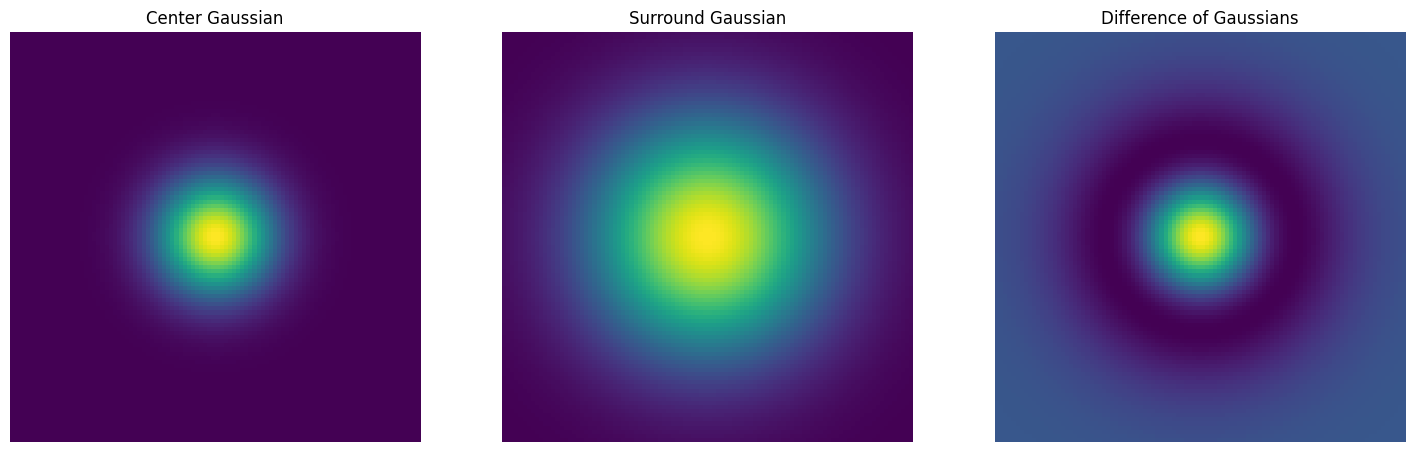

In [ ]:
# Define a 2D spatial domain
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Define a 2D Gaussian function
def gaussian_2d(X, Y, sigma):
    return np.exp(-(X**2 + Y**2) / (2 * sigma**2))

# Small Gaussian (Center)
sigma1 = 1.0
gauss1 = gaussian_2d(X, Y, sigma1)

# Large Gaussian (Surround)
sigma2 = 2.0
gauss2 = gaussian_2d(X, Y, sigma2)

# Compute the Difference of Gaussians
dog = gauss1 - 0.5 * gauss2  # Scale the surround to control its relative influence

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
cmap = 'viridis'

# Center Gaussian
ax[0].imshow(gauss1, extent=(-5, 5, -5, 5), cmap=cmap)
ax[0].set_title('Center Gaussian')
ax[0].axis('off')

# Surround Gaussian
ax[1].imshow(gauss2, extent=(-5, 5, -5, 5), cmap=cmap)
ax[1].set_title('Surround Gaussian')
ax[1].axis('off')

# Difference of Gaussians
ax[2].imshow(dog, extent=(-5, 5, -5, 5), cmap=cmap)
ax[2].set_title('Difference of Gaussians')
ax[2].axis('off')

plt.show()


#### Place Cell

Place cells are neurons that enhance the brain's ability to navigae through environments. The `PlaceCell` class models the behavior of place cells, which includes neural activation calculation based on positions and analysis of spatial relationships.

In [ ]:
class PlaceCells(object):

    def __init__(self, options, us=None):
        # number of place cells
        self.Np = options.Np
        # receptive field size
        self.sigma = options.place_cell_rf
        # scales the surround inhibition
        self.surround_scale = options.surround_scale
        # dimensions of the environment
        self.box_width = options.box_width
        self.box_height = options.box_height
        # whether the environment has periodic boundary conditions
        self.is_periodic = options.periodic
        # Difference of Gaussians
        self.DoG = options.DoG
        self.device = options.device
        self.softmax = torch.nn.Softmax(dim=-1)

        # Randomly generate place cell centers across environment
        # np.random.seed(0)
        # usx = np.random.uniform(-self.box_width / 2, self.box_width / 2, (self.Np,))
        # usy = np.random.uniform(-self.box_width / 2, self.box_width / 2, (self.Np,))
        # self.us = torch.tensor(np.vstack([usx, usy]).T)

        # or, load centers from example_pc_centers.npy
        self.us = torch.tensor(np.load('./example_pc_centers.npy')).to(self.device)

    # computes the activation levels of all place cells in response to a single position under DoG mechanism
    # each place cell's activation is influenced by its distance from the given position, modulated by the place cell's receptive field size
    def get_activation(self, pos):
        '''
        Get place cell activations for a given position.

        Args:
            pos: 2d position of shape [batch_size, sequence_length, 2].

        Returns:
            outputs: Place cell activations with shape [batch_size, sequence_length, Np].
        '''

        # calculate the abs distance between position and all place cell centers
        d = torch.abs(pos[:, :, None, :] - self.us[None, None, ...]).float()

        # adjust distances for periodic boundary conditions
        if self.is_periodic:
            dx = d[:, :, :, 0]
            dy = d[:, :, :, 1]
            dx = torch.minimum(dx, self.box_width - dx)
            dy = torch.minimum(dy, self.box_height - dy)
            d = torch.stack([dx, dy], axis=-1)

        norm2 = (d ** 2).sum(-1)

        # initial value of place cell activation
        # probabilistic representation of place cell activity based on proximity
        outputs = self.softmax(-norm2 / (2 * self.sigma**2))

        # DoG mechanism
        if self.DoG:
            outputs -= self.softmax(-norm2 / (2 * self.surround_scale * self.sigma**2))

            # Shift and scale outputs so that they lie in [0, 1].
            min_output,_ = outputs.min(-1, keepdims=True)
            outputs += torch.abs(min_output)
            outputs /= outputs.sum(-1, keepdims=True)
        return outputs

    def get_nearest_cell_pos(self, activation, k=3):
        '''
        Decode position using centers of k maximally active place cells.

        Args:
            activation: Place cell activations of shape [batch_size, sequence_length, Np].
            k: Number of maximally active place cells with which to decode position.

        Returns:
            pred_pos: Predicted 2d position with shape [batch_size, sequence_length, 2].
        '''

        # find the indices of the top k activated place cells
        _, idxs = torch.topk(activation, k=k)
        # the mean of these positions is calculated to estimate the decoded position
        pred_pos = self.us[idxs].mean(-2)
        return pred_pos

    def grid_pc(self, pc_outputs, res=32):
        ''' Interpolate place cell outputs onto a grid'''
        coordsx = np.linspace(-self.box_width / 2, self.box_width / 2, res)
        coordsy = np.linspace(-self.box_height / 2, self.box_height / 2, res)
        grid_x, grid_y = np.meshgrid(coordsx, coordsy)
        grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T

        pc_outputs = pc_outputs.reshape(-1, self.Np)

        T = pc_outputs.shape[0]
        pc = np.zeros([T, res, res])
        for i in range(len(pc_outputs)):
            gridval = scipy.interpolate.griddata(self.us.cpu(), pc_outputs[i], grid)
            pc[i] = gridval.reshape([res, res])

        return pc

    def compute_covariance(self, res=30):
        '''Compute spatial covariance matrix of place cell outputs'''
        pos = np.array(np.meshgrid(np.linspace(-self.box_width / 2, self.box_width / 2, res),
                         np.linspace(-self.box_height / 2, self.box_height / 2, res))).T

        pos = torch.tensor(pos)
        pos = pos.to(self.device)

        pc_outputs = self.get_activation(pos).reshape(-1, self.Np).cpu()

        C = pc_outputs@pc_outputs.T
        Csquare = C.reshape(res, res, res, res)

        Cmean = np.zeros([res, res])
        for i in range(res):
            for j in range(res):
                Cmean += np.roll(np.roll(Csquare[i, j], -i, axis=0), -j, axis=1)

        Cmean = np.roll(np.roll(Cmean, res // 2, axis=0), res // 2, axis=1)

        return Cmean

#### RNN model

The `RNN` model is a neural network designed to integrate place cell and grid cell dynamics for spatial navigation tasks. It contains several layers:
- Encoder layer to transform place cell to grid cell
- RNN layer for processing sequential data as the grid cell activation
- Decoder layer to transform grid cell back to place cell

In [ ]:
class RNN(torch.nn.Module):
    def __init__(self, options, place_cells):
        super(RNN, self).__init__()
        # number of place cells
        self.Np = options.Np
        # number of grid cells
        self.Ng = options.Ng
        self.sequence_length = options.sequence_length
        self.weight_decay = options.weight_decay
        self.place_cells = place_cells

        # transform place cell inputs to grid cell
        self.encoder = torch.nn.Linear(self.Np, self.Ng, bias=False)
        # process sequential data
        self.RNN = torch.nn.RNN(input_size=2,
                                hidden_size=self.Ng,
                                nonlinearity=options.activation,
                                bias=False)
        # transform grid cell outputs back to place cell
        self.decoder = torch.nn.Linear(self.Ng, self.Np, bias=False)
        # output normalization
        self.softmax = torch.nn.Softmax(dim=-1)

    def g(self, inputs):
        '''
        Compute grid cell activations.
        Args:
            inputs: Batch of 2d velocity inputs with shape [batch_size, sequence_length, 2]
            and initial place cell activation with shape [batch_size, Np].

        Returns:
            g: Batch of grid cell activations with shape [batch_size, sequence_length, Ng].
        '''
        # v: velocity, p0: initial place cell state
        v, p0 = inputs
        init_state = self.encoder(p0)[None]
        g, _ = self.RNN(v, init_state)
        return g


    def predict(self, inputs):
        '''
        Predict place cell code.
        Args:
            inputs: Batch of 2d velocity inputs with shape [batch_size, sequence_length, 2].

        Returns:
            place_preds: Predicted place cell activations with shape
                [batch_size, sequence_length, Np].
        '''
        place_preds = self.decoder(self.g(inputs))

        return place_preds


    def compute_loss(self, inputs, pc_outputs, pos):
        '''
        Compute avg. loss and decoding error.
        Args:
            inputs: Batch of 2d velocity inputs with shape [batch_size, sequence_length, 2].
            pc_outputs: Ground truth place cell activations with shape
                [batch_size, sequence_length, Np].
            pos: Ground truth 2d position with shape [batch_size, sequence_length, 2].

        Returns:
            loss: Avg. loss for this training batch.
            err: Avg. decoded position error in cm.
        '''
        y = pc_outputs
        preds = self.predict(inputs)
        yhat = self.softmax(self.predict(inputs))
        # cross entropy loss
        loss = -(y * torch.log(yhat)).sum(-1).mean()

        # Weight regularization
        loss += self.weight_decay * (self.RNN.weight_hh_l0 ** 2).sum()

        # Compute decoding error
        pred_pos = self.place_cells.get_nearest_cell_pos(preds)
        err = torch.sqrt(((pos - pred_pos) ** 2).sum(-1)).mean()

        return loss, err

In [ ]:
from visualize import save_ratemaps


class Trainer(object):
    def __init__(self, options, model, trajectory_generator, restore=True):
        self.options = options
        self.model = model
        self.trajectory_generator = trajectory_generator
        lr = self.options.learning_rate
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.loss = []
        self.err = []

        if restore and os.path.isfile('./example_trained_weights.npy'):
            weights = np.load('./example_trained_weights.npy', allow_pickle=True)
            with torch.no_grad():
                for p, w in zip(self.model.parameters(), weights):
                    w_tensor = torch.tensor(w)
                    p.copy_(w_tensor.T)
            print("Restored trained model from {}".format('example_trained_weights.npy'))
        else:
            if not os.path.isdir(self.ckpt_dir):
                os.makedirs(self.ckpt_dir, exist_ok=True)
            print("Initializing new model from scratch.")
            print("Saving to: {}".format(self.ckpt_dir))

    def train_step(self, inputs, pc_outputs, pos):
        '''
        Train on one batch of trajectories.

        Args:
            inputs: Batch of 2d velocity inputs with shape [batch_size, sequence_length, 2].
            pc_outputs: Ground truth place cell activations with shape
                [batch_size, sequence_length, Np].
            pos: Ground truth 2d position with shape [batch_size, sequence_length, 2].

        Returns:
            loss: Avg. loss for this training batch.
            err: Avg. decoded position error in cm.
        '''
        self.model.zero_grad()

        loss, err = self.model.compute_loss(inputs, pc_outputs, pos)

        loss.backward()
        self.optimizer.step()

        return loss.item(), err.item()

    def train(self, n_epochs: int = 1000, n_steps=10, save=True):
        '''
        Train model on simulated trajectories.

        Args:
            n_steps: Number of training steps
            save: If true, save a checkpoint after each epoch.
        '''

        # Construct generator
        gen = self.trajectory_generator.get_generator()

        # tbar = tqdm(range(n_steps), leave=False)
        for epoch_idx in range(n_epochs):
            for step_idx in range(n_steps):
                inputs, pc_outputs, pos = next(gen)
                loss, err = self.train_step(inputs, pc_outputs, pos)
                self.loss.append(loss)
                self.err.append(err)

                print('Epoch: {}/{}. Step {}/{}. Loss: {}. Err: {}cm'.format(
                    epoch_idx, n_epochs, step_idx, n_steps,
                    np.round(loss, 2), np.round(100 * err, 2)))

            if save:
                # Save checkpoint
                ckpt_path = os.path.join(self.ckpt_dir, 'epoch_{}.pth'.format(epoch_idx))
                torch.save(self.model.state_dict(), ckpt_path)
                torch.save(self.model.state_dict(), os.path.join(self.ckpt_dir,
                                                                 'most_recent_model.pth'))

                # Save a picture of rate maps
                save_ratemaps(self.model, self.trajectory_generator,
                              self.options, step=epoch_idx)

In [ ]:
from trajectory_generator import TrajectoryGenerator

In [ ]:
# Training options and hyperparameters
class Options:
    pass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
options = Options()

options.save_dir = './models/'
options.n_steps = 100         # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment
options.device = device       # cpu or gpu

In [ ]:
place_cells = PlaceCells(options)
model = RNN(options, place_cells).to(device)
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

Restored trained model from example_trained_weights.npy


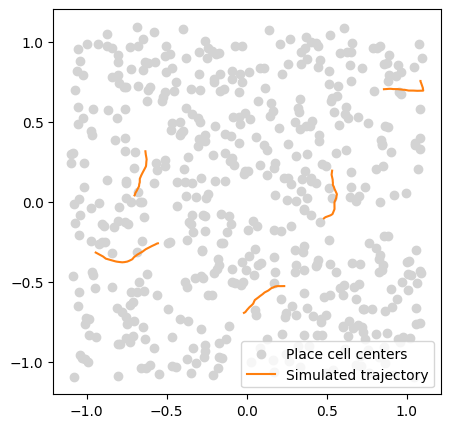

In [ ]:
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
us = place_cells.us.cpu()
# size: [batch_size, sequence_length, 2]
pos = pos.cpu()

plt.figure(figsize=(5, 5))
plt.scatter(us[:, 0], us[:, 1], c='lightgrey', label='Place cell centers')
for i in range(5):
    plt.plot(pos[:, i, 0], pos[:, i, 1], label='Simulated trajectory', c='C1')
    if i == 0:
        plt.legend()

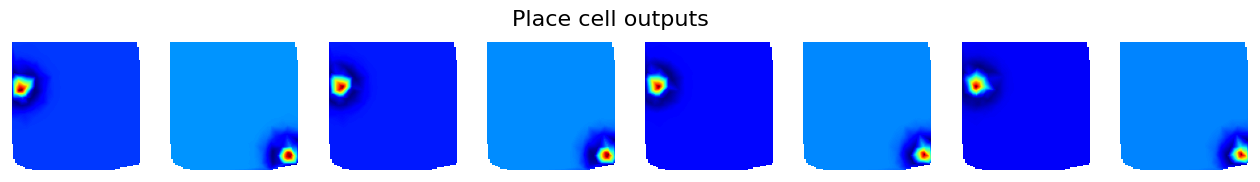

In [ ]:
pc_outputs = pc_outputs.reshape(-1, options.Np).detach().cpu()
pc = place_cells.grid_pc(pc_outputs[::100], res=100)

plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')

plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

(-0.5, 10.5, -0.5, 10.5)

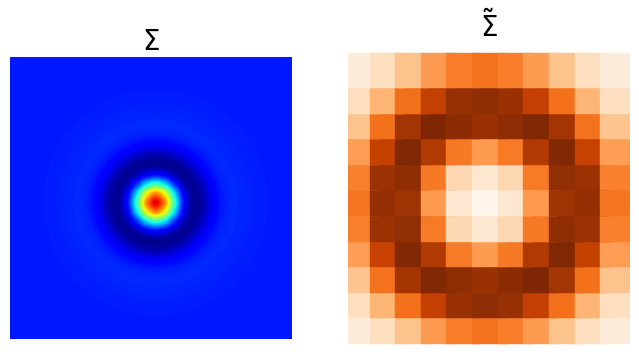

In [ ]:
# Visualize place cell covariance matrix
# aims to understand how place cell activities correlate across different spatial locations
Cmean = place_cells.compute_covariance(res=30)

# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0, 0] = 0

# represent the localized nature of place cell responses
# a gradual decrease outward indicates that activations are more strongly correlated at nearby positions
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(Cmean, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

# ring-like pattern shows that certain spatial frequencies are dominant
# highlights underlying periodic structures
plt.subplot(122)
width = 6
idxs = np.arange(-width + 1, width)
x2, y2 = np.meshgrid(np.arange(2 * width - 1), np.arange(2 * width - 1))
plt.scatter(x2, y2, c=np.abs(Ctilde)[idxs][:, idxs],
            s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off')

(-1.1, 1.1)

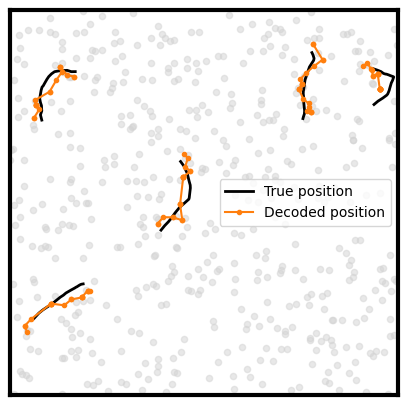

In [ ]:
inputs, pos, _ = trajectory_generator.get_test_batch()
pos = pos.cpu()
pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs)).cpu()
us = place_cells.us.cpu()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[:, i, 0], pos[:, i, 1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[:, i, 0], pred_pos[:, i, 1], '.-',
             c='C1', label='Decoded position')

    if i == 0:
        plt.legend()

plt.scatter(us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)

plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width / 2, options.box_width / 2])
plt.ylim([-options.box_height / 2, options.box_height / 2])

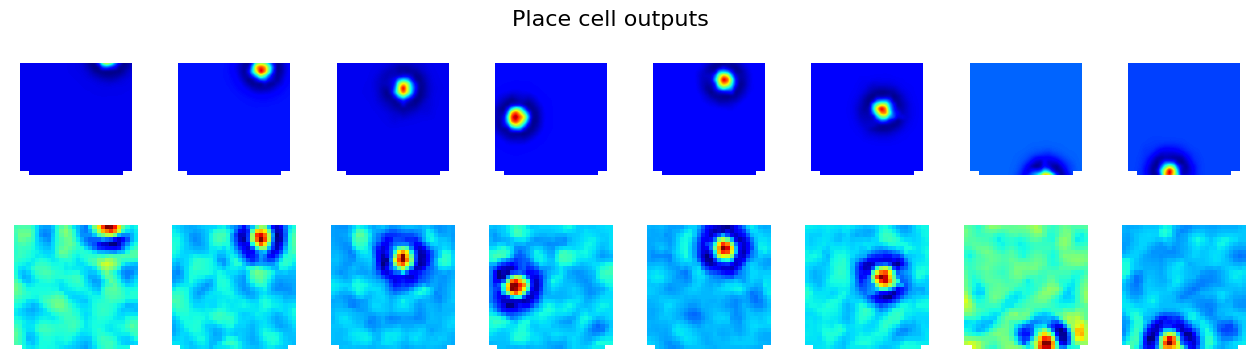

In [ ]:
# Visualize predicted place cell outputs
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
preds = model.predict(inputs)
preds = preds.reshape(-1, options.Np).detach().cpu()
pc_outputs = model.softmax(pc_outputs).reshape(-1, options.Np).cpu()
pc_pred = place_cells.grid_pc(preds[:100])
pc = place_cells.grid_pc(pc_outputs[:100])

plt.figure(figsize=(16, 4))

for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(pc[2 * i], cmap='jet', interpolation='gaussian')
    if i == 0:
        plt.ylabel('True')
    plt.axis('off')

for i in range(8):
    plt.subplot(2, 8, i + 9)
    plt.imshow(pc_pred[2 * i], cmap='jet')
    if i == 0:
        plt.ylabel('Predicted')
    plt.axis('off')

plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

#### Ratemaps

Code below shows how grid cells respond over space by creating rate maps that reflect neural activity in different spatial locations.

In [ ]:
def compute_ratemaps(model, trajectory_generator, options, res=20, n_avg=None, Ng=512, idxs=None):
    '''Compute spatial firing fields'''

    if not n_avg:
        n_avg = 1000 // options.sequence_length

    if not np.any(idxs):
        idxs = np.arange(Ng)
    idxs = idxs[:Ng]

    g = np.zeros([n_avg, options.batch_size * options.sequence_length, Ng])
    pos = np.zeros([n_avg, options.batch_size * options.sequence_length, 2])

    activations = np.zeros([Ng, res, res])
    counts = np.zeros([res, res])

    # iterates n_avg times to average over multiple trajectory batches
    for index in tqdm(range(n_avg)):
        # for each trajectory batch, retrive inputs and target positions
        inputs, pos_batch, _ = trajectory_generator.get_test_batch()
        # get neural activations
        g_batch = model.g(inputs).detach().cpu().numpy()

        pos_batch = np.reshape(pos_batch.cpu(), [-1, 2])
        g_batch = g_batch[:, :, idxs].reshape(-1, Ng)

        g[index] = g_batch
        pos[index] = pos_batch

        # convert positions to grid indices
        x_indices = torch.clamp(((pos_batch[:, 0] + options.box_width / 2) / options.box_width * res).long(), 0, res-1)
        y_indices = torch.clamp(((pos_batch[:, 1] + options.box_height / 2) / options.box_height * res).long(), 0, res-1)

        # keep track of how many times each position is visited
        np.add.at(counts, (x_indices.numpy(), y_indices.numpy()), 1)
        # accumulate activations at the corresponding positions
        for i in range(Ng):
            np.add.at(activations[i], (x_indices.numpy(), y_indices.numpy()), g_batch[:, i])

    # normalize activations
    for x in range(res):
        for y in range(res):
            if counts[x, y] > 0:
                activations[:, x, y] /= counts[x, y]

    g = g.reshape([-1, Ng])
    pos = pos.reshape([-1, 2])

    rate_map = activations.reshape(Ng, -1)

    return activations, rate_map, g, pos

In [ ]:
res = 30
n_avg = 10
Ng = options.Ng
activations, rate_map, g, pos = compute_ratemaps(model,
                                                 trajectory_generator,
                                                 options,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=Ng)

# Compute a set of lo-res maps to use for evalutaing grid score
lo_res = 20
_, rate_map_lores, _, _ = compute_ratemaps(model,
                                          trajectory_generator,
                                          options,
                                          res=lo_res,
                                          n_avg=n_avg,
                                          Ng=Ng)

100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


(-0.5, 539.5, 539.5, -0.5)

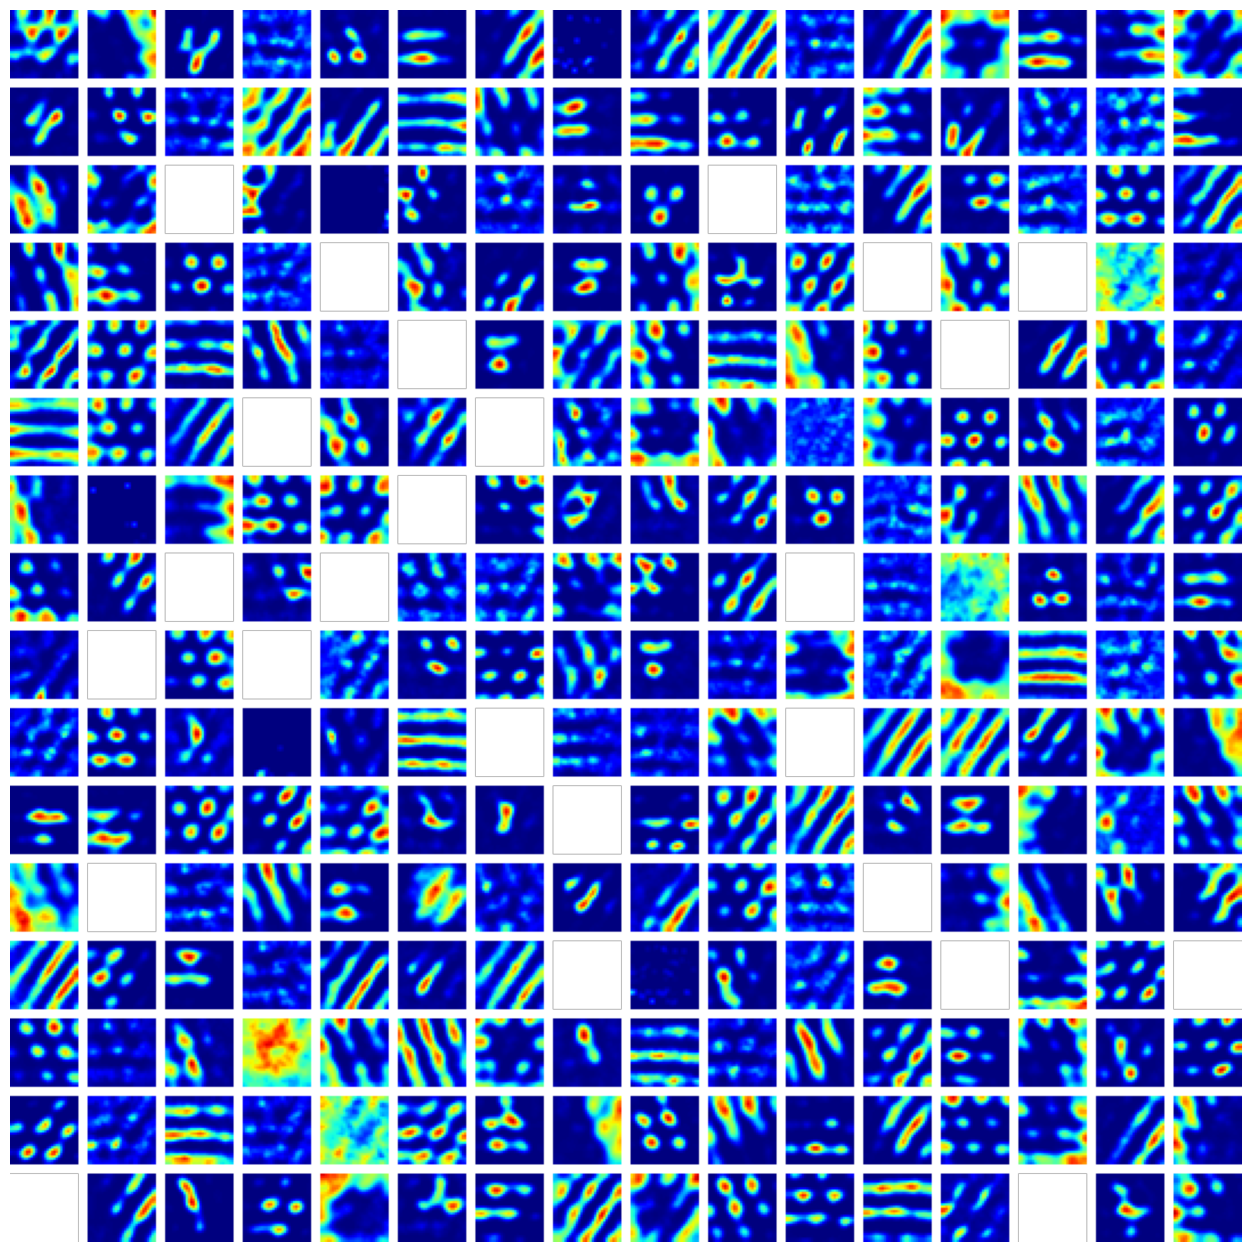

In [ ]:
from visualize import plot_ratemaps

n_plot = 256
plt.figure(figsize=(16, 4 * n_plot // 8 ** 2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off')

#### Speed tuning of grid cells

In [ ]:
g = []
# speed
vs = []
# heading direction
hds = []
navg = 20
for index in tqdm(range(navg), leave=False, desc='Computing ratemaps'):
    inputs, pos_batch, _ = trajectory_generator.get_test_batch()
    # v size: [batch_size, sequence_length, 2]
    v = inputs[0].cpu().numpy()
    # g_batch size: [batch_size, sequence_length, Ng]
    g_batch = model.g(inputs).detach().cpu().numpy()

    vx, vy = v[:, :, 0], v[:, :, 1]
    # v size: [batch_size, sequence_length]
    v = np.sqrt(vx ** 2 + vy ** 2)
    hd = np.arctan2(vy, vx)
    # g_batch size: [batch_size * sequence_length, Ng]
    g_batch = np.reshape(g_batch, (-1, Ng))

    g.append(g_batch)
    # v.ravel() size: [batch_size * sequence_length,]
    vs.append(v.ravel())
    hds.append(hd)

# g shape: [navg * batch_size * sequence_length, Ng]
g = np.stack(g).reshape([-1, Ng])
# vs shape: [navg * batch_size * sequence_length,]
vs = np.stack(vs).ravel()
# hds shape: [navg * batch_size * sequence_length,]
hds = np.stack(hds).ravel()

In [ ]:
# Construct speed tuning curves
speed_curves = []
for i in tqdm(range(Ng)):
    # divides vs into 10 bins (from 0 to 0.05), then calculates the average activation value of g[:, i] within each bin
    # which forms the speed tuning curve
    stat, bins, _ = scipy.stats.binned_statistic(vs, g[:, i], bins=10, range=(0, 0.05))
    speed_curves.append(stat)

# shape: [Ng, 10]
# the speed tuning curve of each neuron is represented by 10 averaged values
speed_curves = np.stack(speed_curves)

100%|██████████| 4096/4096 [00:23<00:00, 176.46it/s]


Text(0.5, 0.92, 'Speed')

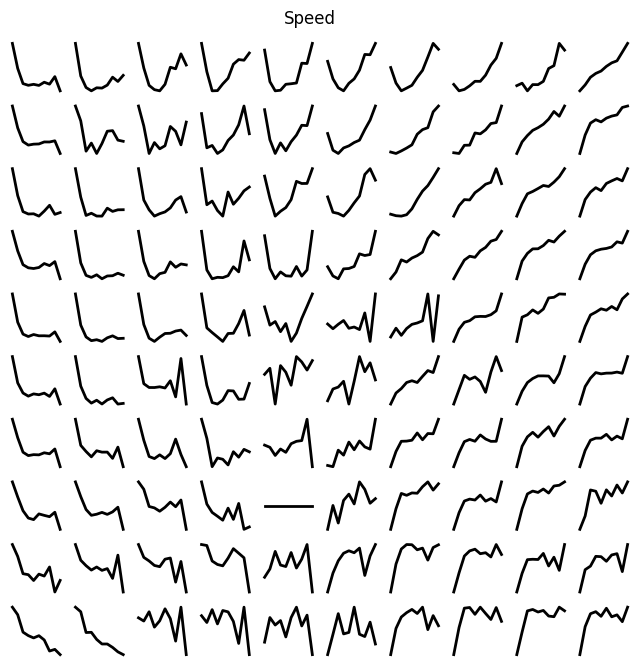

In [ ]:
# Plot a sampling of tuning curves in 2d PCA space
nplot = 10
# U: principal component of the speed curves
U, S, V = np.linalg.svd(speed_curves - speed_curves.mean(-1, keepdims=True))
# second principal component as x, shape: [Ng,]
x = -U[:, 1]
# first principal component as y, shape: [Ng,]
y = -U[:, 0]

# normalize x into [0, nplot]
x = nplot * (scipy.special.erf((x - x.mean()) / x.std()) + 1) / 2
y = nplot * (scipy.special.erf((y - y.mean()) / y.std()) + 1) / 2

plt.figure(figsize=(8, 8))
for i in range(nplot):
    for j in range(nplot):
        plt.subplot(nplot, nplot, i * nplot + j + 1)
        # identifies indices of points that fall into the current [i, j] cell
        candidates = (x > i) * (x < i + 1) * (y > j) * (y < j + 1)
        idxs = np.arange(Ng)[candidates]

        try:
            # randomly choose an index
            plt.plot(speed_curves[np.random.choice(idxs)], c='black', linewidth=2)
        except:
            pass
        plt.axis('off')
plt.suptitle('Speed', y=0.92)

### Part 2: Locality-Sensitive Hashing Algorithm

Locality-Sensitive Hashing (LSH) is a technique for approximating the nearest neighbour search in high-dimensional spaces. LSH works by hashing input items so that similar items are likely to be mapped to the same "buckets" with high probability. This is achieved by using hashing functions that intentially reduce the dimensionality of the input data, thereby increasing the chance of collision for similar items while keeping different items mostly separate.

The bio-inspired FlyLSH algorithm ([paper](https://www.science.org/doi/10.1126/science.aam9868)) draws inspiration from biological processes, such as the neural coding in the olfactory system of fruit flies. Unlike traditional LSH, which uses dense Gaussian projections, bio-inspried LSH typically use sparse binary projections. For example, in step 2, the projection neurons expand the dimensionality, projecting to 2000 Kenyon cells connected by a sparse, binary random projection matrix. In step 3, the KCs receive feedback inhibition from the anterior paired lateral neuron, which leaves only top 5% of KCs to remain firing spikes for the odor.

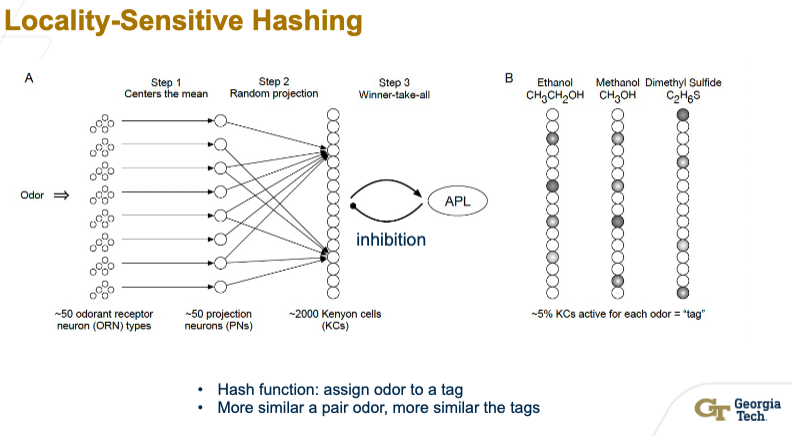

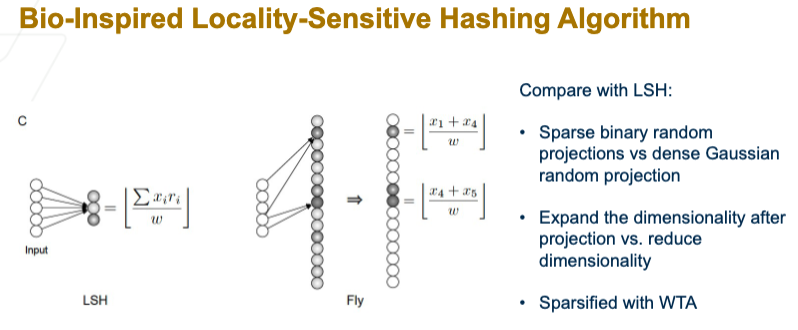

In [ ]:
import torch
from torchvision import datasets, transforms


# Load MNIST Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

train_data, train_labels = next(iter(train_loader))
test_data, test_labels = next(iter(test_loader))

train_data = train_data.view(train_data.shape[0], -1).numpy()
test_data = test_data.view(test_data.shape[0], -1).numpy()

train_labels = train_labels.numpy()
test_labels = test_labels.numpy()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 17137655.06it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 489545.93it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 2019276.10it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 5416698.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def generate_dense_random_matrix(dim_in, dim_out):
    # TODO: add your implementation here.
    return np.random.normal(0, 1, size=(dim_in, dim_out))

def lsh_hash(data, projection):
    # Dense Gaussian projection
    transformed = np.dot(data, projection)
    return (transformed > 0).astype(int)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# Generate random projections
dense_projection = generate_dense_random_matrix(train_data.shape[1], 256)

# Hash the data
start_time = time.time()
lsh_train_hashes = lsh_hash(train_data, dense_projection)
lsh_test_hashes = lsh_hash(test_data, dense_projection)
lsh_duration = time.time() - start_time

# Train and test KNN classifier, which operates by finding the most similar data points in the training set
# and making predictions
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(lsh_train_hashes, train_labels)
lsh_predictions = knn.predict(lsh_test_hashes)
lsh_accuracy = accuracy_score(test_labels, lsh_predictions)

print(f"LSH Accuracy: {lsh_accuracy}, Duration: {lsh_duration}")

LSH Accuracy: 0.9284, Duration: 1.5128037929534912


### Part 3: After-class questions

Please ensure that each section of the report includes your own analysis. Simply answering the questions without providing additional explanations may result in a deduction of points.

#### 3.1 Grid score and manifold distance (6 points)

##### 3.1.1 Grid score (3 points)

The `GridScorer` class inside `scores.py` is for calculating and analyzing the spatial properties of grid cell rate maps. It evaluates the "gridness" of rate maps using spatial autocorrelograms (SACs). It measures the hexagonal/grid structure of firing patterns by rotating the SAC and comparing correlations at specific angles (e.g., 60°, 90°).

`grid_score_60` evaluates hexagonal symmetry specifically by comparing correlation values at angles like 60° and 120°, which are characteristic of hexagonal patterns.

`grid_score_90` evaluates square grid-like symmetry by comparing the correlation at 90° against angles like 45° and 135°.

A higher grid score generally indicates that the neuron's firing pattern is more periodic, especially in a spatially structured manner.

In [ ]:
from scores import GridScorer

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width = options.box_width
box_height = options.box_height
coord_range = ((-box_width / 2, box_width / 2), (-box_height / 2, box_height / 2))
masks_parameters = zip(starts, ends.tolist())

# TODO: add your implementation here.
# instantiation of GridScorer
scorer = GridScorer(lo_res, ?, ?)

score_60 = []
score_90 = []
max_60_mask = []
max_90_mask = []
sac = []
max_60_ind = []

for rm in tqdm(rate_map_lores):
    rm = rm.reshape(lo_res, lo_res)
    # HINT: use scorer.get_scores function.
    s60, s90, m60, m90, s, ind60 =
    score_60.append(s60)
    score_90.append(s90)
    max_60_mask.append(m60)
    max_90_mask.append(m90)
    sac.append(s)
    max_60_ind.append(ind60)

In [ ]:
# sorts the score in descending order
idxs = np.flip(np.argsort(score_60))
Ng = options.Ng

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16, 4 * n_plot // 8 ** 2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores ' + str(np.round(score_60[idxs[0]], 2))
             + ' -- ' + str(np.round(score_60[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off')

# Plot medium grid scores
plt.figure(figsize=(16, 4 * n_plot // 8 ** 2))
rm_fig = plot_ratemaps(activations[idxs[Ng // 4:]], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores ' + str(np.round(score_60[idxs[Ng // 2]], 2))
             + ' -- ' + str(np.round(score_60[idxs[Ng // 2 + n_plot]], 2)),
            fontsize=16)
plt.axis('off')

# Plot low grid scores
plt.figure(figsize=(16, 4 * n_plot // 8 ** 2))
rm_fig = plot_ratemaps(activations[np.flip(idxs)], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores ' + str(np.round(score_60[idxs[-n_plot]], 2))
             + ' -- ' + str(np.round(score_60[idxs[-1]], 2)),
            fontsize=16)
plt.axis('off')

In [ ]:
plt.hist(score_60, range=(-1, 2.5), bins=15)
plt.xlabel('Grid score')
plt.ylabel('Count')

##### 3.1.2 Manifold distance (3 points)

The code below visualizes the similarity between the activation patterns of selected grid cells. It selects 500 grid cells with the highest grid scores and computes distances between their rate maps relative to a set of predefined origin points.

In [ ]:
# Keeping only top 500 grid cells
n_grid_cells = 500
grid_sort = np.flip(np.argsort(score_60))
# a 3x3 grid of reference point coordinates, each indicating a specific point in the center-adjusted rate map
origins = np.stack(np.mgrid[:3, :3] - 1) * lo_res // 4 + lo_res // 2
print(origins)

fig = plt.figure(figsize=(8,8))
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, 3 * i + j + 1)
        origin_idx = np.ravel_multi_index((origins[0, i, j], origins[1, i, j]), (res, res))
        # rate map values for the top 500 grid cells at the specified origin_idx, shape: [500, 1]
        r0 = rate_map[grid_sort[:n_grid_cells], origin_idx, None]
        # TODO: compute the Euclidean distance between r0 and other rate map values for each grid cell
        dists =
        im = plt.imshow(dists.reshape(res, res) / np.max(dists),
                        cmap='viridis_r', interpolation='gaussian')
        plt.axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.74])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.locator_params(nbins=3)
cbar.ax.tick_params(labelsize=20)
cbar.outline.set_visible(False)

#### 3.2 Neuron coding strategy: population coding and Bayesian decoder (3 points)

In population coding, neurons respond to specific range of a variable $s$ (e.g., preferred direction) and create a distribution of responses across a population. Using Bayes' theorem, we can estimate the posterior $P(s|r)$, the probability of a variable given the observed activity $r$.

$$
P(s|r) = \frac{P(r|s)P(s)}{\sum_s P(r|s)P(s)}
$$


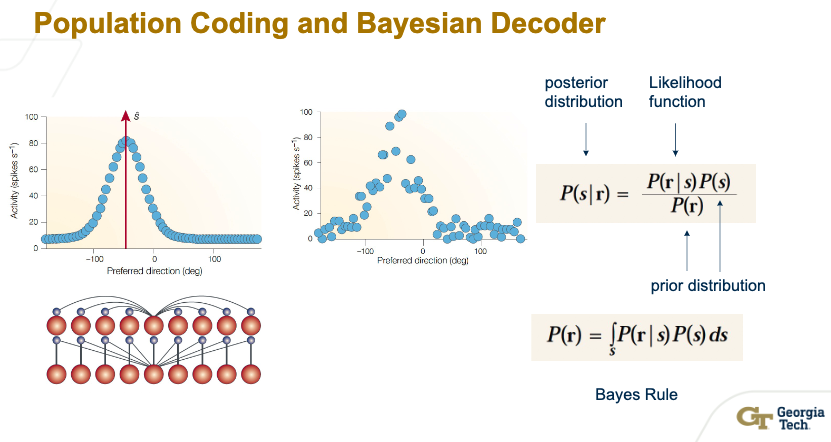

In [ ]:
# Define parameters
n_neurons = 50  # Number of neurons
stimulus_range = np.linspace(-180, 180, 360)  # Possible directions in degrees
preferred_directions = np.linspace(-180, 180, n_neurons)  # Each neuron has a preferred direction
sigma = 40  # Tuning curve width (std dev of Gaussian)
# Prior over stimulus (uniform in this case)
P_s = np.ones_like(stimulus_range) / len(stimulus_range)

# Simulate spiking responses for a given stimulus
def generate_spike_response(stimulus, preferred_directions, sigma):
    """
    Generates a spike response for each neuron based on the stimulus.
    """
    # TODO: model the neuron's tuning curve P(r|s) as a Gaussian centered at each neuron's preferred direction
    return


# Bayesian decoder
def bayesian_decoder(response, preferred_directions, stimulus_range, sigma, P_s):
    """
    Decodes the stimulus direction using Bayes’ rule given neural responses.
    """
    likelihoods = np.zeros(len(stimulus_range))
    # for each stimulus, calculate the difference between observed and expected responses
    # using Gaussian approximation of the likelihood
    for i, s in enumerate(stimulus_range):
        # TODO: add your implementation here.
        expected_response =
        # likelihood formula: exp(-0.5 * sum((response - expected_response) ** 2))
        likelihoods[i] =
    # Posterior is proportional to likelihood * prior
    P_r_given_s = likelihoods * P_s
    # TODO: add your implementation of normalization to get posterior
    P_s_given_r =
    return P_s_given_r


# Simulated ground truth stimulus
true_stimulus = 30  # Example stimulus direction

# Generate spike response from neurons
observed_response = generate_spike_response(true_stimulus, preferred_directions, sigma)

# Decode the stimulus using the Bayesian decoder
posterior = bayesian_decoder(observed_response, preferred_directions, stimulus_range, sigma, P_s)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stimulus_range, posterior, label='Posterior')
plt.axvline(true_stimulus, color='r', linestyle='--', label='True stimulus')
plt.xlabel('Direction (degrees)')
plt.ylabel('Posterior Probability')
plt.title('Bayesian Decoding of Direction from Neural Responses')
plt.legend()
plt.show()

#### 3.3 FlyLSH implementation (6 points)

In traditional LSH, we use a dense Gaussian matrix to project the high-dimensional data to low-dimensional space. On the contrary, FlyLSH will expand the dimensionality of input data using sparse binary projections. Then, it will use Winner-Take-All mechanism to leave only top 5% neurons. In this section, key tasks include:
- Implementation of FlyLSH. (3 points)
- Hyperparameter tuning of `dim_out`: explore how varying `dim_out` affects the performance by creating a 2D plot that compares the test accuracy of KNN and computation time of hashing. This analysis will help evaluate the trade-offs between computational cost and accuracy. (3 points)

In [ ]:
import numpy as np

def generate_sparse_random_matrix(dim_in, dim_out, sparsity):
    # TODO: add your implementation of generating a sparse binary matrix where each element is 1 with a probability equal to sparsity.
    return

def fly_hash(data, projection):
    # TODO: add your implementation of sparse binary projection and WTA mechanism here.
    # Projection of original data
    transformed =
    # leave only top 5% neurons
    threshold =
    return (transformed >= threshold).astype(int)

# TODO: tuning dim_out and plot the accuracy vs computation time.
dim_out =
sparsity = 0.1
sparse_projection = generate_sparse_random_matrix(train_data.shape[1], dim_out, sparsity)

# Hash the data
start_time = time.time()
fly_train_hashes = fly_hash(train_data, sparse_projection)
fly_test_hashes = fly_hash(test_data, sparse_projection)
fly_duration = time.time() - start_time

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(fly_train_hashes, train_labels)
fly_predictions = knn.predict(fly_test_hashes)
fly_accuracy = accuracy_score(test_labels, fly_predictions)

print(f"Fly Hash Accuracy: {fly_accuracy}, Duration: {fly_duration}")

#### 3.4: Bonus - Head direction tuning curves (2 points)

The implementation for head direction tuning curves is very similar to speed tuning. We have already tracked `hds` for you.

In [ ]:
# TODO: add your implementation for head direction tuning curves.